# Exploratory Data Analysis (EDA)

# [**\*\*Open in NBViewer to see Interactive Maps\*\***](https://nbviewer.jupyter.org/github/nathann3/airbnb_pricer_seattle/blob/master/notebooks/0_EDA.ipynb)

https://nbviewer.jupyter.org/github/nathann3/airbnb_pricer_seattle/blob/master/notebooks/0_EDA.ipynb

# Imports

In [1]:
import folium
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
import seaborn as sns

from branca.element import Template, MacroElement
from folium.plugins import HeatMap, TimestampedGeoJson
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

sns.set_style("dark")

# Download data

In [2]:
def download_data(fp, url=None):
    if not url:
        url = 'http://data.insideairbnb.com/united-states/wa/seattle/2021-07-14/data/listings.csv.gz'
    r = requests.get(url, stream=True)
    block_size = 1024
    total_size = int(r.headers.get('content-length', 0))
    num_iterables = math.ceil(total_size / block_size)

    # Download if not already downloaded.
    if not os.path.exists(fp):
        dir, name = os.path.split(fp)
        if not os.path.exists(dir):
            os.makedirs(dir)
        with open(fp, "wb") as file:
            for data in tqdm(
                r.iter_content(block_size), total=num_iterables, unit="KB", unit_scale=True
            ):
                file.write(data)

In [3]:
fp = os.path.join('..', 'data', 'listings.csv.gz')
download_data(fp)

In [4]:
raw_listings = pd.read_csv(fp)
raw_listings.shape

(4096, 74)

In [5]:
raw_listings.sample(5, random_state=123)

id  ... reviews_per_month
553    8290643  ...              5.03
3731  49949336  ...               NaN
3241  48394342  ...              0.61
2334  38130168  ...              1.30
3880  50390965  ...              1.00

[5 rows x 74 columns]

# Drop useless features

Looking at some features, we notice that we can drop some columns because they don't inherently contain useful information to use in our data exploration and analysis: ```listing_url```, ```scrape_id```, ```last_scraped```, ```picture_url```, ```host_thumbnail_url```, and ```calendar_last_scraped```.

Lastly, we notice that ```has_availability``` has only 1 unique value.

We will go ahead and drop these.

In [6]:
raw_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            4096 non-null   int64  
 1   listing_url                                   4096 non-null   object 
 2   scrape_id                                     4096 non-null   int64  
 3   last_scraped                                  4096 non-null   object 
 4   name                                          4096 non-null   object 
 5   description                                   4087 non-null   object 
 6   neighborhood_overview                         2898 non-null   object 
 7   picture_url                                   4096 non-null   object 
 8   host_id                                       4096 non-null   int64  
 9   host_url                                      4096 non-null   o

In [7]:
def print_all(df):
    """Displays all rows of DataFrame"""
    pd.set_option('display.max_rows', None)
    display(df)
    pd.set_option('display.max_rows', 10)

print_all(raw_listings.nunique())

id                                              4096
listing_url                                     4096
scrape_id                                          1
last_scraped                                       2
name                                            3967
description                                     3663
neighborhood_overview                           2337
picture_url                                     4014
host_id                                         2204
host_url                                        2204
host_name                                       1297
host_since                                      1567
host_location                                    129
host_about                                      1556
host_response_time                                 4
host_response_rate                                43
host_acceptance_rate                              70
host_is_superhost                                  2
host_thumbnail_url                            

In [8]:
drop_listings = raw_listings.drop(['listing_url', 'scrape_id', 'last_scraped',
                                   'picture_url', 'host_thumbnail_url',
                                   'calendar_last_scraped', 'has_availability'], axis=1)

# Missing Values

```neighborhood```, ```neighborhood_overview``` and ```host_about``` has almost a quarter of missing data, mainly because they are optional fields. neighbourhood can be assessed from he location of the listing and thus we can ignore and drop it.

```host_response_time``` and ```host_response_rate``` have the same number of missing values. Maybe due to not having a guest book thier listing yet. host_acceptance_rate also have missing data probably for the same reason.

```host_neighborhood``` is also optional which explains the 300 missing values.

```bathrooms``` is all missing, but we can use ```bathroom_text``` so we can drop this feature. We can also drop ```calendar_updated```.

```bedrooms``` and ```beds``` are missing because some are studios and sometimes listers forget to put that information. We can extract the type of listing from the listing's title can input studios as 0.

```review``` features all have similar amounts of missing data. This might be because these are new listings and they do not have any reviews yet. We sould look at the ```number_of_reviews``` feature to confirm.

```license``` has a quarter of missing values, probably because most people do not have a license.


In [9]:
missing_vals = raw_listings.isnull().sum()
print_all(missing_vals[missing_vals != 0])

description                       9
neighborhood_overview          1198
host_location                     7
host_about                      984
host_response_time              436
host_response_rate              436
host_acceptance_rate            376
host_neighbourhood              317
neighbourhood                  1198
bathrooms                      4096
bathrooms_text                    2
bedrooms                        618
beds                             92
calendar_updated               4096
first_review                    763
last_review                     763
review_scores_rating            763
review_scores_accuracy          768
review_scores_cleanliness       768
review_scores_checkin           768
review_scores_communication     768
review_scores_location          768
review_scores_value             768
license                        1119
reviews_per_month               763
dtype: int64

In [10]:
drop_listings = drop_listings.drop(['neighbourhood', 'bathrooms', 'calendar_updated'], axis=1)

# Numerical variables

We separate the categorcal data from the numerical. We also take out text data like the name and the description of the listing.


Nominal categorical variables: ```host_location```, ```host_response_time```, ```host_is_superhost```, ```host_has_profile_pic```, ```host_identity_verified```, ```neighbourhood_cleansed```, ```neighbourhood_group_cleansed```, ```property_type```, ```room_type```, ```instant_bookable```.


Text variables : ```name```, ```description```, ```neighborhood_overview```, ```host_name```, ```host_neighbourhood```, ```amenities```, ```license```

Numeric variables: ```host_total_listings_count```, ```latitude```, ```longitude```, ```accommodates```, ```bathrooms_text```, ```bedrooms```, ```beds```, ```price```, ```minimum_nights```, ```maximum_nights```, ```minimum_minimum_nights```, ```maximum_minimum_nights```, ```minimum_maximum_nights```, ```maximum_maximum_nights```, ```minimum_nights_avg_ntm```, ```maximum_nights_avg_ntm```,  ```availability_30```, ```availability_60```, ```availability_90```, ```availability_365```, ```number_of_reviews```, ```review_scores_rating```, ```review_scores_accuracy```, ```review_scores_cleanliness```, ```review_scores_checkin```, ```review_scores_communication```, ```review_scores_location```, ```review_scores_value```, ```calculated_host_listings_count```, ```calculated_host_listings_count_entire_homes```,  ```calculated_host_listings_count_private_rooms```,  ```calculated_host_listings_count_shared_rooms```,```reviews_per_month```

In [11]:
cat_cols = ['host_location', 'host_response_time', 'host_is_superhost',
 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'instant_bookable']

text_cols = ['name', 'description', 'neighborhood_overview', 'host_name',
             'host_neighbourhood', 'amenities', 'license']

num_cols = ['host_total_listings_count', 'latitude', 'longitude',
            'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'price',
            'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
            'maximum_minimum_nights', 'minimum_maximum_nights',
            'maximum_maximum_nights', 'minimum_nights_avg_ntm',
            'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
            'availability_90', 'availability_365', 'number_of_reviews',
            'review_scores_rating', 'review_scores_accuracy',
            'review_scores_cleanliness', 'review_scores_checkin',
            'review_scores_communication', 'review_scores_location',
            'review_scores_value', 'calculated_host_listings_count',
            'calculated_host_listings_count_entire_homes',
            'calculated_host_listings_count_private_rooms',
            'calculated_host_listings_count_shared_rooms', 'reviews_per_month']

In [12]:
drop_listings[num_cols].head()

host_total_listings_count  ...  reviews_per_month
0                          2  ...               0.58
1                          5  ...               2.45
2                          9  ...               1.12
3                          0  ...               0.52
4                          0  ...               0.58

[5 rows x 33 columns]

We notice ```bathrooms_text``` and ```price``` are text so we convert them to numeric.

In [13]:
 drop_listings['price'] = drop_listings['price'].replace('[\$,]', '', regex=True).astype(float)

 drop_listings['bathrooms_text'] = drop_listings['bathrooms_text'].replace(['Shared half-bath', 'Half-bath', 'Private half-bath'],'0.5 baths').fillna('0')
 drop_listings['bathrooms_text'] = [''.join(re.findall('\d*\.?\d+', item)) for item in drop_listings['bathrooms_text']]
 drop_listings['bathrooms_text'] = drop_listings['bathrooms_text'].astype(float)

50% of hosts have 2 listings or less, while 75% have 11 lists or less. There is a host that has over 2,000 listings!

On average listings accomodate 3.75 people, but the average number of beds is 1.95. 75% of listings are 2 bedrooms or less.

Prices range from just \$19 a day to \$3750 a day, the median price being \$135.

The most common minimum number of nights to book is surprisingly 30, with 2 and then 1 following. This might signal a rise in short term rentals and sublets.

On average, a listing has 180 days available in the year, meaning about half of the year has already been booked. Looking at availability 30, 60 and 90, we can see that Airbnbs most commonly have only 0-5 days vaccant in the future, demonstrating high demand for Airbnbs.

For number of reviews, we see a wide range starting from 0 reviews to 1018 reviews. 50% of listings only have 20 reviews or lower and 75% listings have 85 reviews or lower. The average listing will get about 3 reviews a month, with the top 99% of listings recieving more than 20 reviews a month.

We also see that an overwhelmingly amount of positively rated listings. 75% of all listings are greater than 4.5, with the average total rating for a listings being 4.746.

In [14]:
drop_listings[num_cols].describe()

host_total_listings_count  ...  reviews_per_month
count                4096.000000  ...        3333.000000
mean                  114.835693  ...           3.079898
std                   384.554808  ...           4.809680
min                     0.000000  ...           0.010000
25%                     1.000000  ...           0.740000
50%                     2.000000  ...           1.990000
75%                    11.000000  ...           3.910000
max                  2232.000000  ...         127.270000

[8 rows x 33 columns]

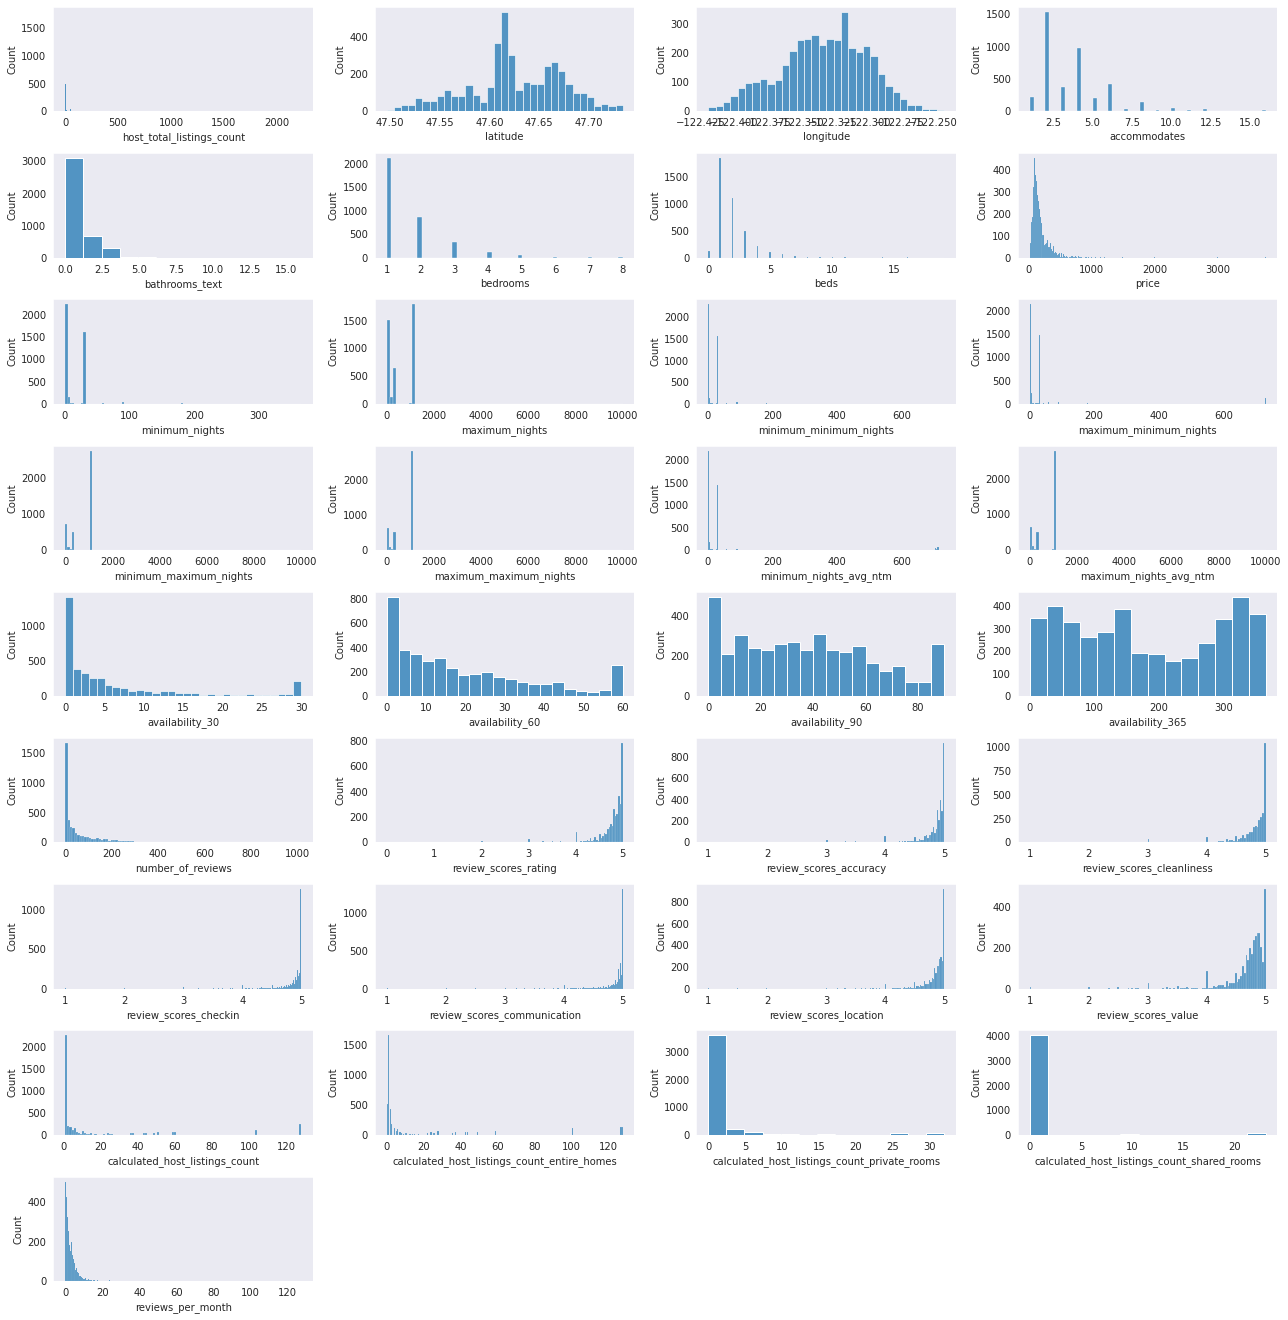

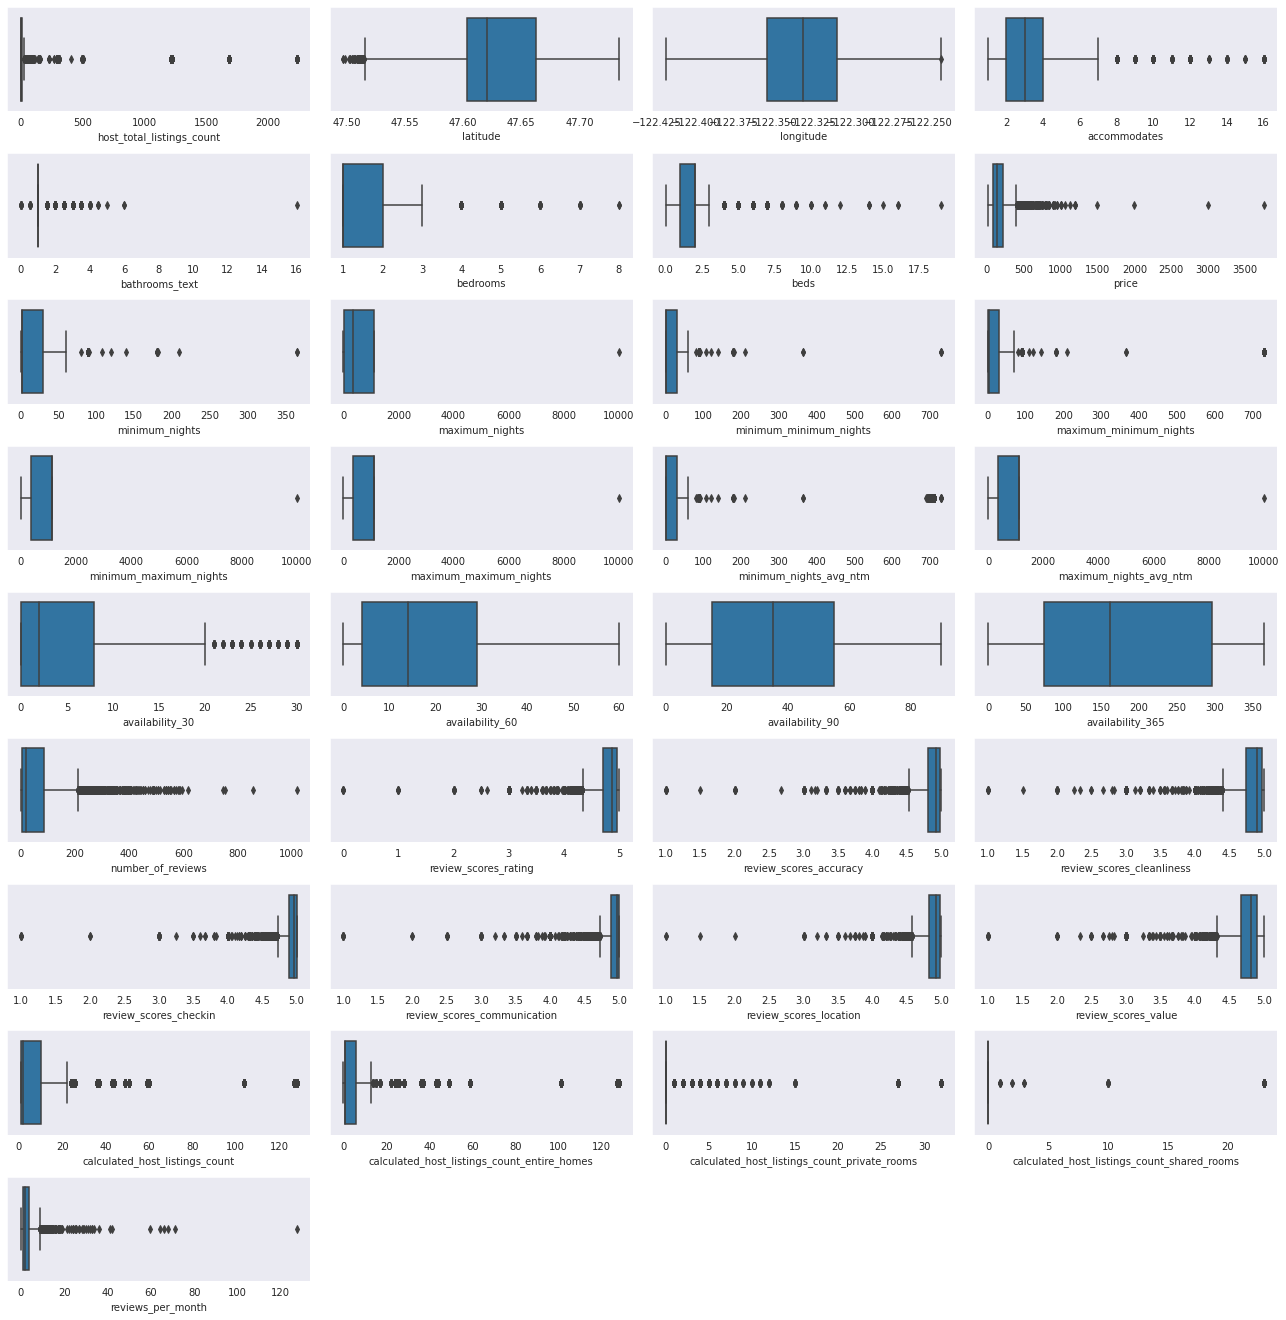

In [15]:
# histograms
fig = plt.figure(figsize=(18, 20))
for index, col in enumerate(drop_listings[num_cols]):
    plt.subplot(10, 4,index+1)
    sns.histplot(drop_listings.loc[:, col], kde=False)
fig.tight_layout(pad=1.0)

# boxplots
fig = plt.figure(figsize=(18, 20))
for index, col in enumerate(drop_listings[num_cols]):
    plt.subplot(10, 4,index+1)
    sns.boxplot(x=drop_listings.loc[:, col])
fig.tight_layout(pad=1.0)

In [16]:
drop_listings['reviews_per_month'].quantile(.99)

17.801199999999945

Other than Other neighbourhoods, Downtown has the most listings, followed by Capitol Hill, a neighbourhood directly adjcent to Downtown.

# Categorical variables.


All but 8 hosts have profile pics. About 40% of hosts are super hosts. The status doesn't seem too special with this in mind. And more than 75% of hosts have their identity verified. Lastly, most hosts respond to a potential booking within a single hour.

Other than Other neighbourhoods, Downtown has the most listings, followed by Capitol Hill, a neighbourhood directly adjcent to Downtown.

The most common listing type is an entire home or apartment, and the least common is a shared room. Listings are almost 50/50 split for being instantly bookable. For half the hosts, approving the renter is important for they are inviting over stangers and damages can be costly to a rental business.



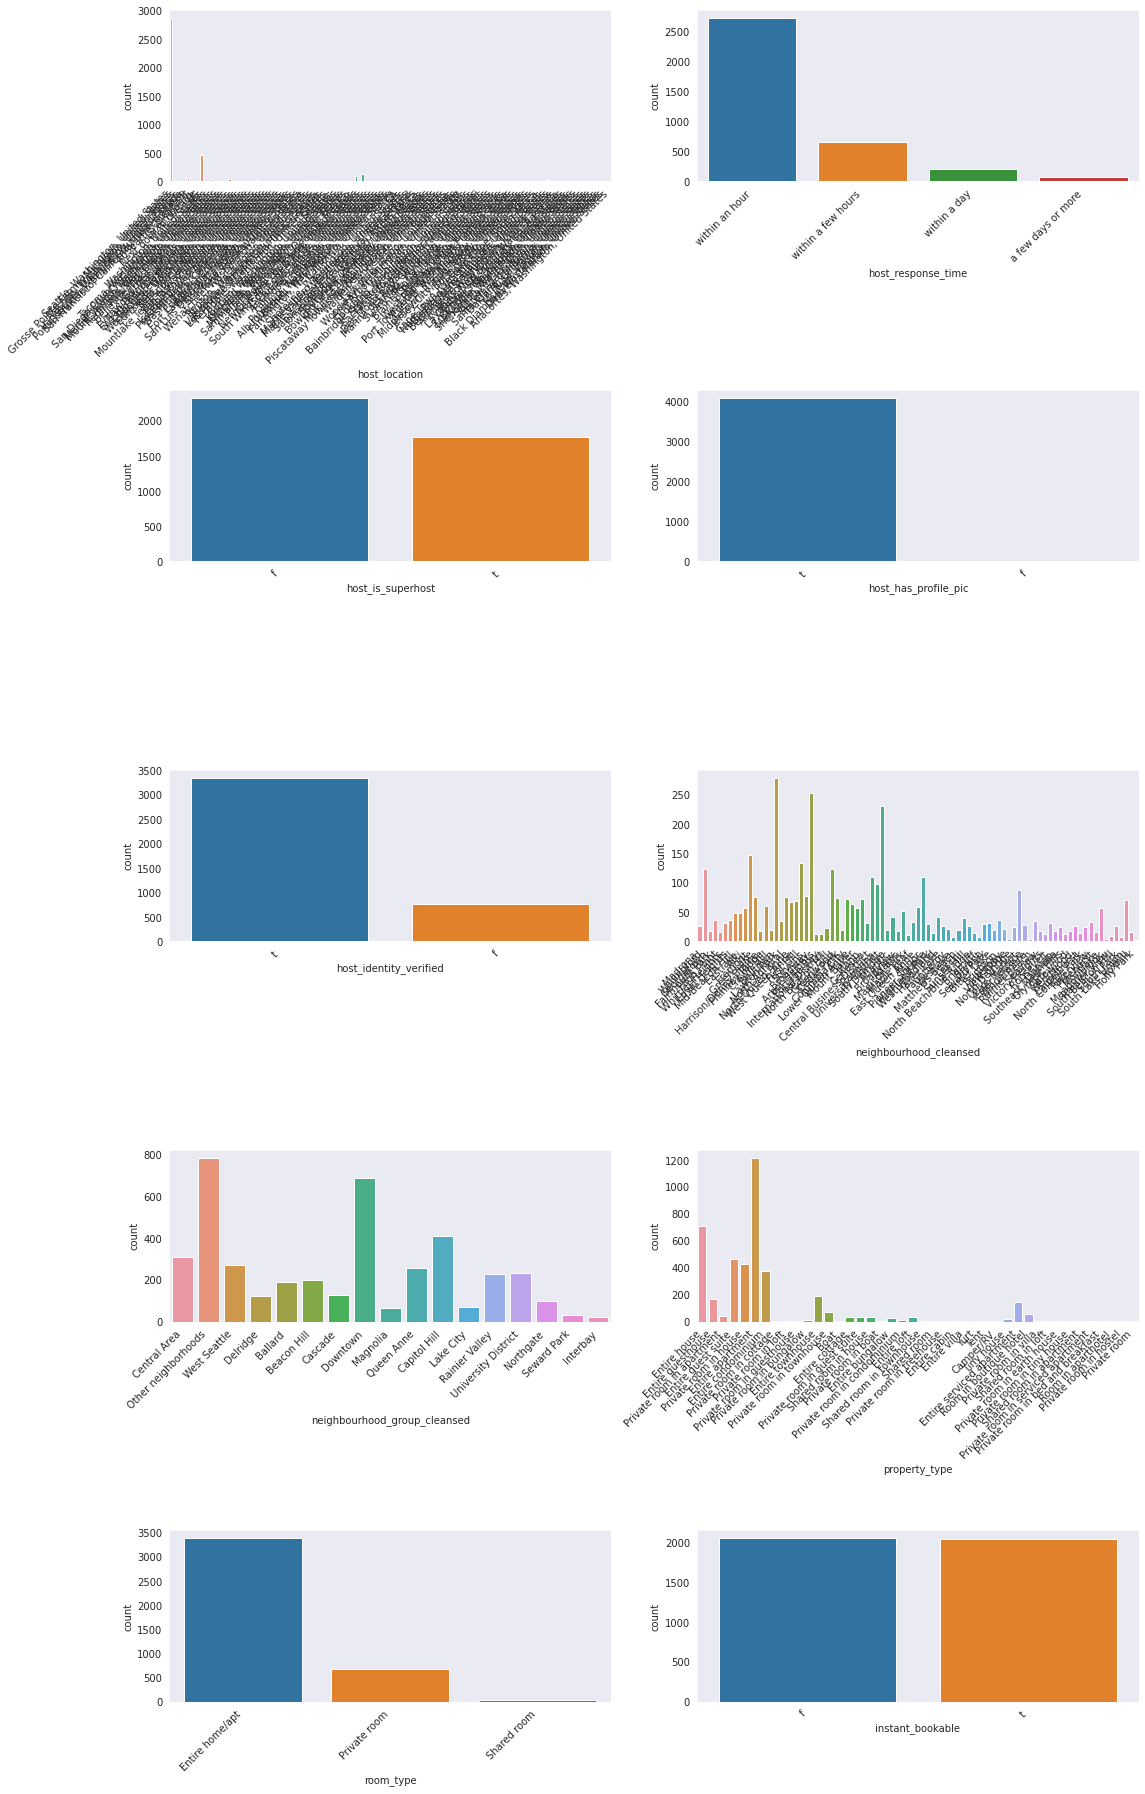

In [17]:
# countplots
fig = plt.figure(figsize=(16, 25))
for index, col in enumerate(drop_listings[cat_cols]):
    plt.subplot(5, 2, index+1)
    count = sns.countplot(x=drop_listings.loc[:, col])
    count.set_xticklabels(count.get_xticklabels(), rotation=45, horizontalalignment='right')
fig.tight_layout(pad=1.0)

# Maps

In [18]:
# Map neighborhoods to colors.
palette = sns.color_palette('muted', drop_listings.neighbourhood_group_cleansed.nunique()).as_hex()
cmap = {neighbourhood: color for neighbourhood, color in zip(drop_listings.neighbourhood_group_cleansed.unique(), palette)}

# Manually set colors for better distinction.
cmap['Lake City'], cmap['Central Area'] = cmap['Central Area'], cmap['Lake City']

Zooming in on the map you can see that downtown has the highest density of Airbnb listings.

In [19]:
# Plot listings by neighborhood.
m = folium.Map(location=[47.61807, -122.42945],
               tiles='cartodbpositron',
               zoom_start=11,
               min_zoom=11)

for i in range(len(drop_listings)):
    folium.CircleMarker(
        location=[drop_listings.iloc[i]['latitude'], drop_listings.iloc[i]['longitude']],
        radius=3,
        color='#000000', # '#808080',
        fill_color=cmap[drop_listings.iloc[i]['neighbourhood_group_cleansed']],
        fill_opacity=0.8,
        weight=1,
   ).add_to(m)

In [20]:
# Add legend.
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Neighbourhoods</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#956cb4;opacity:1;'></span>Ballard</li>
    <li><span style='background:#8c613c;opacity:1;'></span>Beacon Hill</li>
    <li><span style='background:#4878d0;opacity:1;'></span>Capitol Hill</li>
    <li><span style='background:#dc7ec0;opacity:1;'></span>Cascade</li>
    <li><span style='background:#ee854a;opacity:1;'></span>Central Area</li>
    <li><span style='background:#d65f5f;opacity:1;'></span>Delridge</li>
    <li><span style='background:#797979;opacity:1;'></span>Downtown</li>
    <li><span style='background:#dc7ec0;opacity:1;'></span>Interbay</li>
    <li><span style='background:#4878d0;opacity:1;'></span>Lake City</li>
    <li><span style='background:#d5bb67;opacity:1;'></span>Magnolia</li>
    <li><span style='background:#956cb4;opacity:1;'></span>Northgate</li>
    <li><span style='background:#ee854a;opacity:1;'></span>Other neighborhoods</li>
    <li><span style='background:#82c6e2;opacity:1;'></span>Queen Anne</li>
    <li><span style='background:#6acc64;opacity:1;'></span>Rainier Valley</li>
    <li><span style='background:#8c613c;opacity:1;'></span>Seward Park</li>
    <li><span style='background:#d65f5f;opacity:1;'></span>University District</li>
    <li><span style='background:#6acc64;opacity:1;'></span>West Seattle</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

m.get_root().add_child(macro)

We can use first_review as an estimate for the number of Airbnbs throughout the year.

Reviews start from April 25, 2010 to July 14, 2021.

Since all the listings scraped are active today, we will use a cumulative line chart to approximate Airbnb growth in Seattle. The line chart should end with the amount of reviews in the data.

In [21]:
# Convert to datetime.
drop_listings.first_review = pd.to_datetime(drop_listings.first_review)

# Date range.
print('Earliest review:', drop_listings.first_review.min())
print('Latest review:', drop_listings.first_review.max())

Earliest review: 2010-04-25 00:00:00
Latest review: 2021-07-14 00:00:00


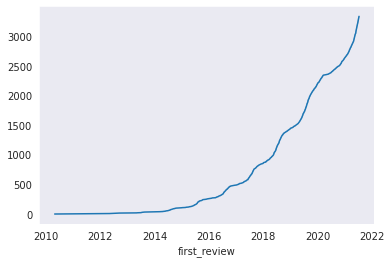

In [22]:
# Cumulative hist of listings through time.
x = drop_listings.first_review.sort_values()
y = np.cumsum(np.full(len(drop_listings.first_review), 1))
sns.lineplot(x=x, y=y)
plt.show()

In [23]:
# Prepare geoson data features.
listings_time = drop_listings[['latitude', 'longitude', 'first_review']].dropna()

features = []
for _, row in listings_time.iterrows():
    feature = {
        'type': 'Feature',
        'geometry': {
            'type':'Point', 
            'coordinates':[row['longitude'],row['latitude']]
        },
        'properties': {
            'time': pd.to_datetime(row['first_review']).__str__(),
            'style': {'color': '#00A699', 'opacity': 0.2},
            'icon': 'circle',
            'iconstyle':{
                'fillColor': '#FF5A5F',
                'fillOpacity': 0.4,
                'stroke': 'true',
                'radius': 3,
                'weight': 1,
            }
        }
    }
    features.append(feature)

In [24]:
# Map of listings through time.
time_map = folium.Map(location=[47.61807, -122.42945], tiles='cartodbpositron', zoom_start=11, min_zoom=11)

TimestampedGeoJson(features,
                  period = 'P2Y',
                  transition_time = 500,
                  auto_play = True).add_to(time_map)

time_map

Highest prices are downtown.

On avergae Downtown has the most expensive Airbnbs, followed by Queen Anne and Beacon Hill.

In [25]:
hmap = folium.Map(location=[47.61807, -122.42945], tiles='cartodbpositron', zoom_start=11, min_zoom=11)
max_amount = float(drop_listings.price.max())

hm_wide = HeatMap(list(zip(drop_listings.latitude.values, drop_listings.longitude.values, drop_listings.price.values)),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=5, blur=5, 
                   max_zoom=1, 
                 )

hmap.add_child(hm_wide)

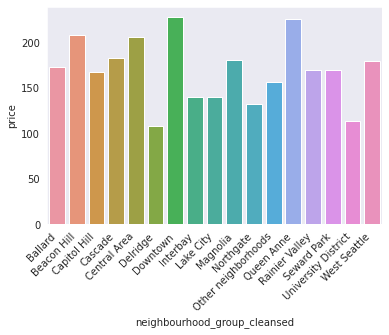

In [26]:
neighbourhood_prices = drop_listings.groupby('neighbourhood_group_cleansed')[['price']].mean().reset_index()
fig = sns.barplot(x='neighbourhood_group_cleansed', y='price', data=neighbourhood_prices)
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Here we can see that Airbnb availability is more spread out / less variable throughout the neighbourhoods than the prices. Downtown has the 3rd highest availability in the future year demonstrating how though Downtown Seattle listings are the most expensive, they also have the highest vacancy, probably due to having the most Airbnbs out of all the neighborhoods.

In [27]:
hmap = folium.Map(location=[47.61807, -122.42945], tiles='cartodbpositron', zoom_start=11, min_zoom=11)
max_amount = float(drop_listings.availability_365.max())

hm_wide = HeatMap(list(zip(drop_listings.latitude.values, drop_listings.longitude.values, drop_listings.availability_365.values)),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=3, blur=4, 
                   max_zoom=1, 
                 )

hmap.add_child(hm_wide)

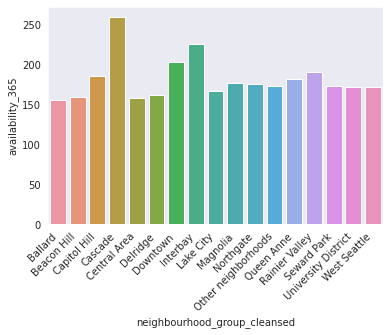

In [28]:
neighbourhood_prices = drop_listings.groupby('neighbourhood_group_cleansed')[['availability_365']].mean().reset_index()
fig = sns.barplot(x='neighbourhood_group_cleansed', y='availability_365', data=neighbourhood_prices)
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

# PCA

In [29]:
# scale data first
scaled_num = StandardScaler().fit_transform(drop_listings[num_cols].dropna())

In [30]:
pca = PCA()
fitted_pca = pca.fit_transform(scaled_num)

In [31]:
pca_df = pd.DataFrame(data=fitted_pca[:, :2],
                      columns = ['pc1', 'pc2'])

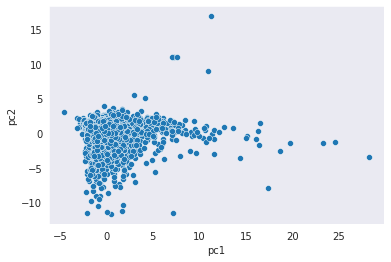

In [32]:
sns.scatterplot(x='pc1', y='pc2', data=pca_df)
plt.show()

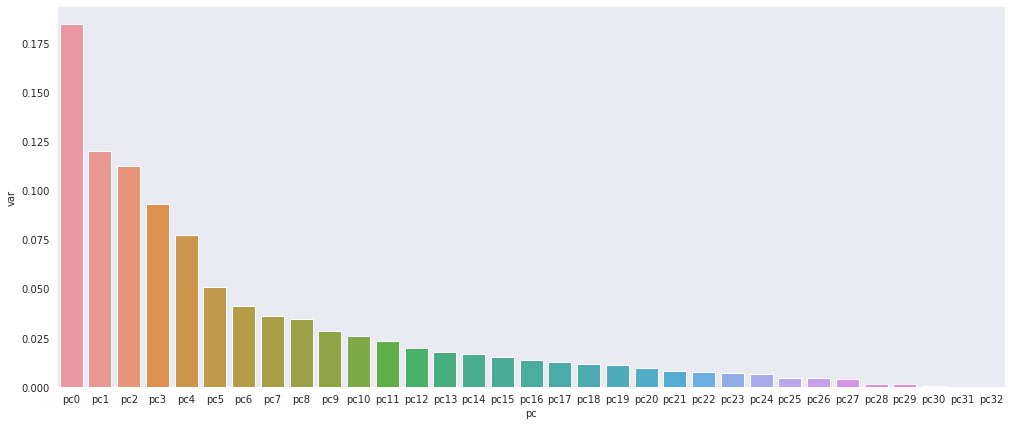

In [33]:
# Plot skree plot.
var_df = pd.DataFrame({'var':pca.explained_variance_ratio_,
                       'pc':[f'pc{i}'for i in range(len(pca.explained_variance_ratio_))]})
plt.figure(figsize=(17,7))
sns.barplot(x='pc', y='var', data=var_df)
plt.show()

# Calendar

In [34]:
fp = os.path.join('..', 'data', 'calendar.csv.gz')
download_data(fp, url='http://data.insideairbnb.com/malta/2021-04-29/data/calendar.csv.gz')

In [35]:
calendar = pd.read_csv(fp, compression='gzip', parse_dates=['date'])

In [36]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3093615 entries, 0 to 3093614
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 165.2+ MB


In [37]:
calendar.price = calendar.price.replace('[\$,]', '', regex=True).astype(float)

Prices are highest in August and on Saturdays. If you are planning a vacation to Seattle, I would recommend you going in the Winter on a Wednesday if you are looking for the best deal.

Though Wednesday is the cheapest day, the avergae price is only $1.75 less than on Saturday, so I would recommend not to keep days of the week in mind, but focus on the month of the year,

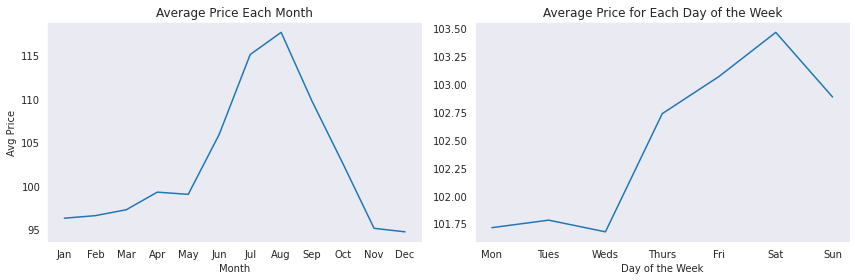

In [38]:
# groupby
by_month = calendar.groupby(calendar["date"].dt.month).mean()
by_dotw = calendar.groupby(calendar["date"].dt.dayofweek).mean()

# map
days = {0: "Mon", 1: "Tues", 2: "Weds", 3: "Thurs", 4: "Fri", 5: "Sat", 6: "Sun"}
months = {
    1: "Jan",
    2: "Feb",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec",
}

# plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Average Price Each Month")
plt.plot(by_month.index.map(months), by_month.price)
plt.xlabel("Month")
plt.ylabel("Avg Price")

plt.subplot(1, 2, 2)
plt.title("Average Price for Each Day of the Week")
plt.plot(by_dotw.index.map(days), by_dotw.price)
plt.xlabel("Day of the Week")
plt.tight_layout()

plt.show()